In [8]:
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import MobileNetV2
from keras.layers import AveragePooling2D, Dropout, Flatten, Dense, Input, GlobalAveragePooling2D, Conv2D, MaxPooling2D
from keras import regularizers
from keras.models import Model, Sequential
from keras.optimizers import Adam
from keras.applications.mobilenet_v2 import preprocess_input
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import pickle
import os
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import cv2
from keras.models import load_model
import Viz

In [2]:
model_name = 'GithubMobile'
def get_pickles(pick_name):
    x_train, x_test, y_train, y_test = pickle.load(open(f'../Pickles/TTS_{pick_name}.p', 'rb'))
    
    return x_train, x_test, y_train, y_test 

x_train, x_test, y_train, y_test  = get_pickles(model_name) 

In [3]:
print(x_train.shape, x_test.shape)
print(y_train.shape, y_test.shape)

(3066, 224, 224, 3) (767, 224, 224, 3)
(3066, 2) (767, 2)


### Mobilenet

In [4]:
def get_mobilenet(dim):
    model = Sequential()
    optimizer = Adam(lr = .0005)
    baseModel = MobileNetV2(weights="imagenet", include_top=False,
        input_tensor=Input(shape=dim))
    
    model.add(baseModel)
    model.add(AveragePooling2D(pool_size=(7, 7)))
    model.add(Flatten(name="flatten"))
    model.add(Dense(256, activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation="sigmoid", name = 'Output'))

    
    for layer in baseModel.layers:
        layer.trainable = False
        
    model.compile(loss = 'binary_crossentropy', optimizer = optimizer, metrics = ['accuracy'])
    return model

In [5]:
early_stopping = EarlyStopping(monitor='val_loss', verbose = 1, patience=10, min_delta = .00075)
model_checkpoint = ModelCheckpoint(f'ModelWeights/Mobilenet_{model_name}.h5', verbose = 1, save_best_only=True,
                                  monitor = 'val_loss')
lr_plat = ReduceLROnPlateau(patience = 5, mode = 'min')
epochs = 2000
batch_size = 32
    

dim = (x_train.shape[1], x_train.shape[2], x_train.shape[3])
print(dim)
mobilenet = get_mobilenet(dim =dim)

    
augmentation =ImageDataGenerator(rotation_range = 20, width_shift_range = .2, height_shift_range = .2, 
                                                       horizontal_flip = True, shear_range = .15, 
                                 fill_mode = 'nearest', zoom_range = .15)
augmentation.fit(x_train)
mobilenet_history = mobilenet.fit_generator(augmentation.flow(x_train, y_train, batch_size = batch_size),
            epochs = epochs, steps_per_epoch = len(x_train) // batch_size, 
     callbacks = [early_stopping, model_checkpoint, lr_plat], validation_data = (x_test, y_test), verbose= 1)

(224, 224, 3)


INFO:plaidml:Opening device "opencl_amd_ellesmere.0"
F:\ProgramFiles\conda\envs\FaceMaskEmotionDetection\lib\site-packages\keras_applications\mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


Epoch 1/2000
61/95 [==================>...........] - ETA: 18s - loss: 0.3750 - acc: 0.8268

INFO:plaidml:Analyzing Ops: 1360 of 2052 operations complete


95/95 [==============================] - 79s 833ms/step - loss: 0.3142 - acc: 0.8607 - val_loss: 0.3401 - val_acc: 0.8585

Epoch 00001: val_loss improved from inf to 0.34006, saving model to ModelWeights/Mobilenet_GithubMobile.h5
Epoch 2/2000
95/95 [==============================] - 30s 317ms/step - loss: 0.1501 - acc: 0.9451 - val_loss: 0.2455 - val_acc: 0.9029

Epoch 00002: val_loss improved from 0.34006 to 0.24549, saving model to ModelWeights/Mobilenet_GithubMobile.h5
Epoch 3/2000
95/95 [==============================] - 30s 314ms/step - loss: 0.1314 - acc: 0.9526 - val_loss: 0.1474 - val_acc: 0.9472

Epoch 00003: val_loss improved from 0.24549 to 0.14741, saving model to ModelWeights/Mobilenet_GithubMobile.h5
Epoch 4/2000
95/95 [==============================] - 30s 313ms/step - loss: 0.1207 - acc: 0.9572 - val_loss: 0.1454 - val_acc: 0.9452

Epoch 00004: val_loss improved from 0.14741 to 0.14540, saving model to ModelWeights/Mobilenet_GithubMobile.h5
Epoch 5/2000
95/95 [=========

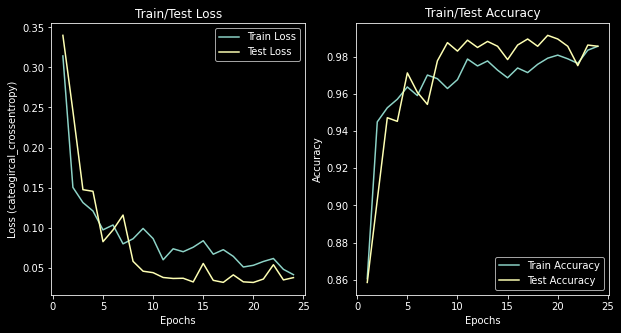

In [9]:
Viz.plot_loss_accuracy(mobilenet_history, 'dark_background')

F:\Python\FaceMaskEmotionDetection\FaceMaskEmotionDetection\Viz.py:138: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax[0].set_xticks(tick_marks, classes)
F:\Python\FaceMaskEmotionDetection\FaceMaskEmotionDetection\Viz.py:139: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax[0].set_yticks(tick_marks, classes)
F:\Python\FaceMaskEmotionDetection\FaceMaskEmotionDetection\Viz.py:158: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  ax[1].set_xticks(tick_marks, classes)
F:\Python\FaceMaskEmotionDetection\FaceMaskEmotionDetection\Viz.py:159: MatplotlibDeprecationWarning: P

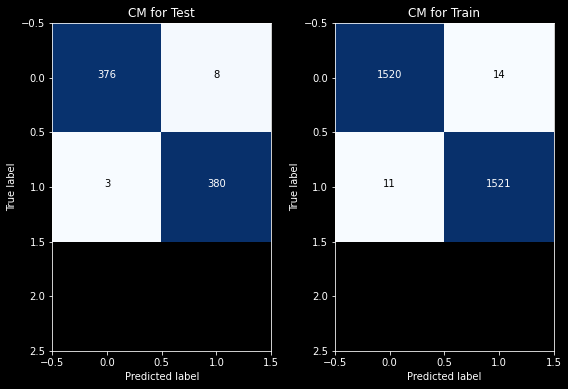

In [10]:
y_test_prob = [np.argmax(i) for i in mobilenet.predict(x_test)]
y_test_labels = [np.argmax(
    i) for i in y_test]
test_cnf = confusion_matrix(y_test_labels, y_test_prob)

y_train_prob = [np.argmax(i) for i in mobilenet.predict(x_train)]
y_train_labels = [np.argmax(i) for i in y_train]
train_cnf = confusion_matrix(y_train_labels, y_train_prob)

#this function creates a confusion matrix given the confusion matrixes of test and train
Viz.plot_model_cm(test_cnf, train_cnf, classes = ['No Mask', 'Mask'], theme = 'dark_background')

In [6]:
assert False

AssertionError: 

In [ ]:

%%javascript
IPython.notebook.save_notebook()

In [ ]:
os.system(r'%windir%\system32\rundll32.exe powrprof.dll,SetSuspendState Hibernate')